# Evaluation of Parametric CNN for Linear Parameters

In [1]:

import argparse
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import json
from sklearn.model_selection import train_test_split
from nn.util_paras import load_preprocess_paras, write_configs, reload_aorta_segs_from_piginfo, normalize_aorta
from tensorflow import distribute as dist
import tensorflow as tf
#from parametrization.reconstruction import reconstruct_lin_tensors_block, reconstruct_lin_uncorrected_tensors_block
import matplotlib.pyplot as plt
from nn.evaluation_fcts import *
from nn.eva_metrics import EvaMetrics
import os
from os.path import join
from glob import glob
from nn.help_function_training import *
import warnings
warnings.filterwarnings('ignore')

2025-01-10 14:06:11.966196: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-10 14:06:12.393072: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Paths 
config_path="/home/pfuchs/nn/configs/"
data_path = "/home/pfuchs/Data/"
mprefix = '/home/pfuchs/nn/models/'

modelpath= "20250109-160205/"

path= mprefix+modelpath
files = glob(join(path, "*.json"), recursive=True)
files = list(sorted(files))
test_pig = 8
sParaType= "Linear"
iParaLen = 42
bResampleParas= True
sNormAorta = "fixed"

## Loading Model

In [3]:

sConfigFile = files[0]
with open(sConfigFile, "r") as file:
    config = json.load(file)
print("Starting with config:\n"+str(config))



# Test pig
iTestpig= 8
iNpigs = len(config["training_examples"])
test_pig = config["training_examples"][iTestpig]
bEvalValidation=False
#todo load vali....


model = tf.keras.models.load_model(mprefix+modelpath+"model.keras")
model.summary()
# for pop_pig in range(n_pigs):
test_pig = [config["training_examples"][iTestpig]]

Starting with config:
{'data_prefix': '/home/pfuchs/Data/Data_npz/PulHyp_k20_20_old/Data_Linear/', 'model_prefix': './models/', 'training_examples': ['P01_PulHyp', 'P02_PulHyp', 'P03_PulHyp', 'P04_PulHyp', 'P05_PulHyp', 'P06_PulHyp', 'P07_PulHyp', 'P08_PulHyp', 'P09_PulHyp', 'P10_PulHyp'], 'aorta_max_length': 1024, 'eit_length': 64, 'epochs': 300, 'batch_size': 16, 'para_size': 42, 'para_type': 'Linear', 'Criteria': 'Versuch Maxpooling in den ersten beiden Conv layern und dann angepasste Strides', 'Minremoved': 'False'}


2025-01-10 14:06:24.072132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46873 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:5f:00.0, compute capability: 8.6
2025-01-10 14:06:24.072729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46306 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:d8:00.0, compute capability: 8.6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 1024, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 22, 342, 4)     │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 22, 342, 4)     │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 22, 342, 4)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 171, 5)     │           505 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 171, 5)     │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 11, 171, 5)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 171, 7)      │           882 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 171, 7)      │            28 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 171, 7)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 171, 9)      │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 171, 9)      │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2, 171, 9)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3078)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 84)             │       258,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 42)             │         3,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 796,045 (3.04 MB)

 Trainable params: 265,331 (1.01 MB)

 Non-trainable params: 50 (200.00 B)

 Optimizer params: 530,664 (2.02 MB)

## Loading Test Data

In [4]:
# Load data ##################################################################
# load test data
print(f"float test pig: {test_pig}")
X_test, y_test, p_test = load_preprocess_paras(
    config["data_prefix"],
    test_pig,
    zero_padding=False,
    shuffle=False,
    eit_length=64,
    aorta_length=1400,
    para_len=iParaLen,
    norm_eit="block",
    norm_aorta=sNormAorta,
    resample_paras=bResampleParas
)

if sNormAorta != 'none':
    y_test, de, f = normalize_aorta(y_test, sNormAorta, deduction=0, facgiven=0)


float test pig: ['P09_PulHyp']
Loading data from /home/pfuchs/Data/Data_npz/PulHyp_k20_20_old/Data_Linear/P09_PulHyp
['/home/pfuchs/Data/Data_npz/PulHyp_k20_20_old/Data_Linear/P09_PulHyp/sample_000086.npz', '/home/pfuchs/Data/Data_npz/PulHyp_k20_20_old/Data_Linear/P09_PulHyp/sample_006029.npz', '/home/pfuchs/Data/Data_npz/PulHyp_k20_20_old/Data_Linear/P09_PulHyp/sample_001873.npz']
['/home/pfuchs/Data/Data_npz/PulHyp_k20_20_old/Data_Linear/P09_PulHyp/sample_000000.npz', '/home/pfuchs/Data/Data_npz/PulHyp_k20_20_old/Data_Linear/P09_PulHyp/sample_000001.npz', '/home/pfuchs/Data/Data_npz/PulHyp_k20_20_old/Data_Linear/P09_PulHyp/sample_000002.npz']
7603
(42, 1024)
7603
(42, 1024)
Min length of EIT segments 22
Max length of EIT segments 44
7600
(64, 1024)
Start normalizing EIT.
(1, 806, 64, 1024)
(64, 1024)
(1, 1471, 64, 1024)
(64, 1024)
(1, 667, 64, 1024)
(64, 1024)
(1, 743, 64, 1024)
(64, 1024)
(1, 404, 64, 1024)
(64, 1024)
(1, 2665, 64, 1024)
(64, 1024)
(1, 844, 64, 1024)
(64, 1024)
7600

## Evaluate Model

In [5]:
y_test_preds = model(X_test)

# Visualization ----------------------------------------------------------------------------- #
# Visualization ----------------------------------------------------------------------------- #
bPlotGraphics = False
bShowGraphics= True

y_test_recon = recon_paras_block(y_test, sParaType)
y_test_preds_recon = recon_paras_block(y_test_preds, sParaType)
print("Reconstruction complete.")
if bResampleParas:
    y_test_recon_a, y_test_preds_recon_a = set_array_len(y_test_recon, y_test_preds_recon, len(y_test_recon[0]))
print("Resampling complete.")

#y_test_real = np.array(reload_aorta_segs_from_piginfo(data_path, p_test, bRemovedMin,bResampled=TP.bResampleParas, iResampleLen=1024, sNormAorta=TP.sNormAorta))
y_test_real = y_test_recon_a




2025-01-10 14:08:08.383258: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


False
recon complete
Resmapled
Recon finished


(1024,)
Pearson correlation coefficient mean 0.9722698401676244
MSE 159.53625584651166
MAE 10.265985247372011
Pearson number 0.9722698401676244


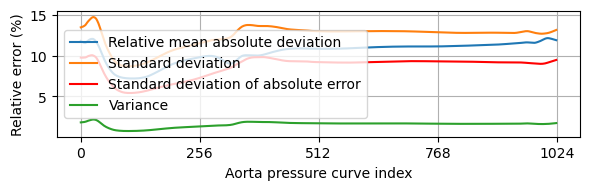

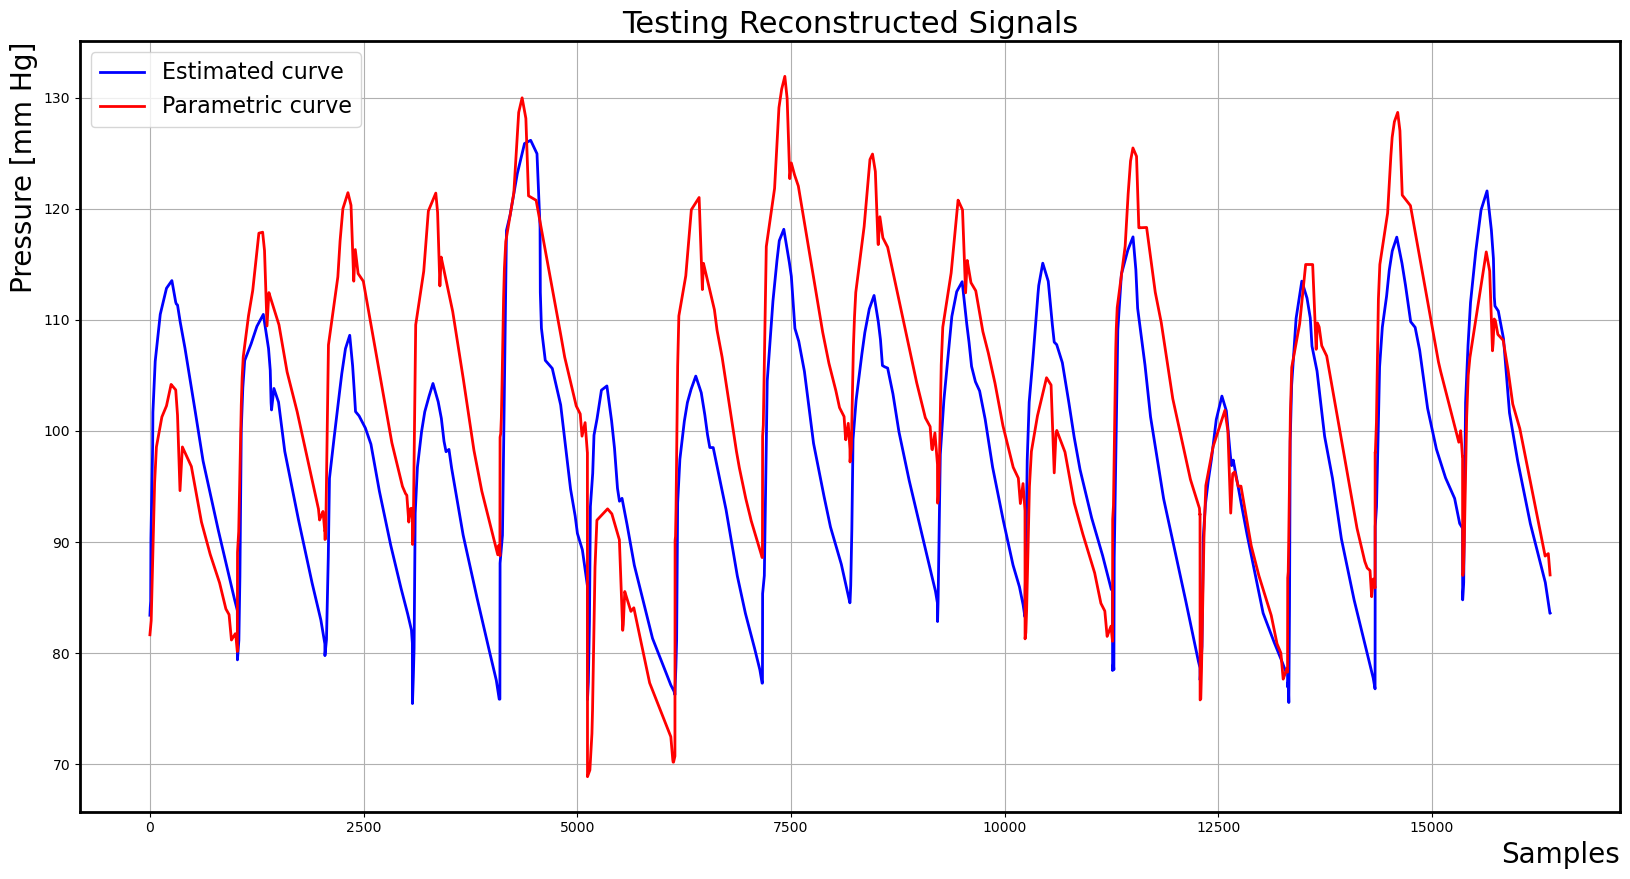

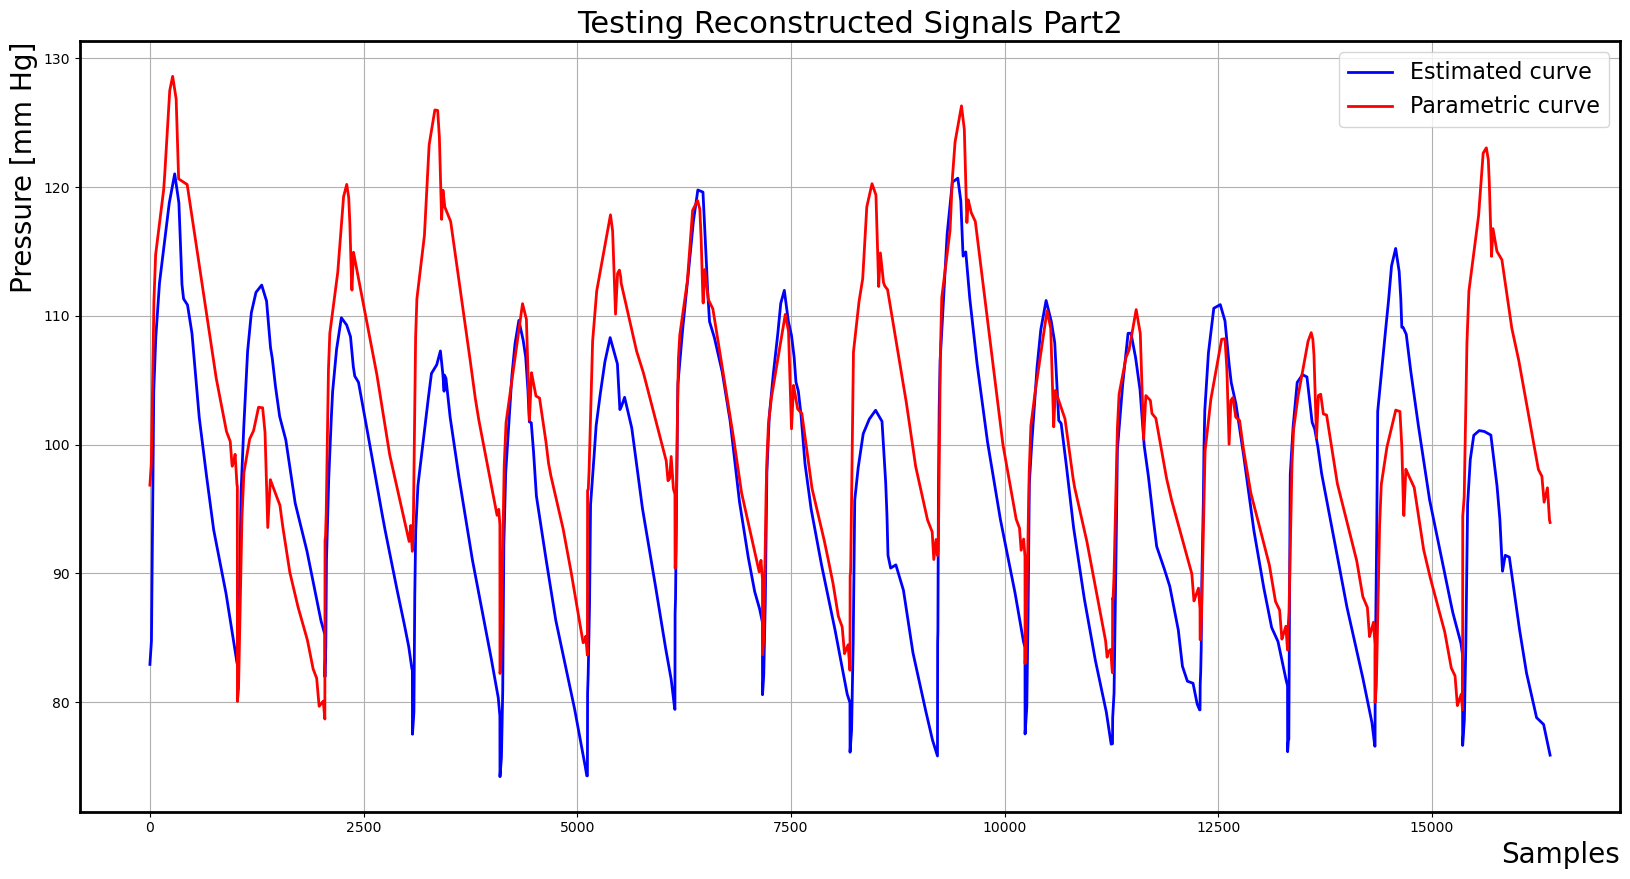

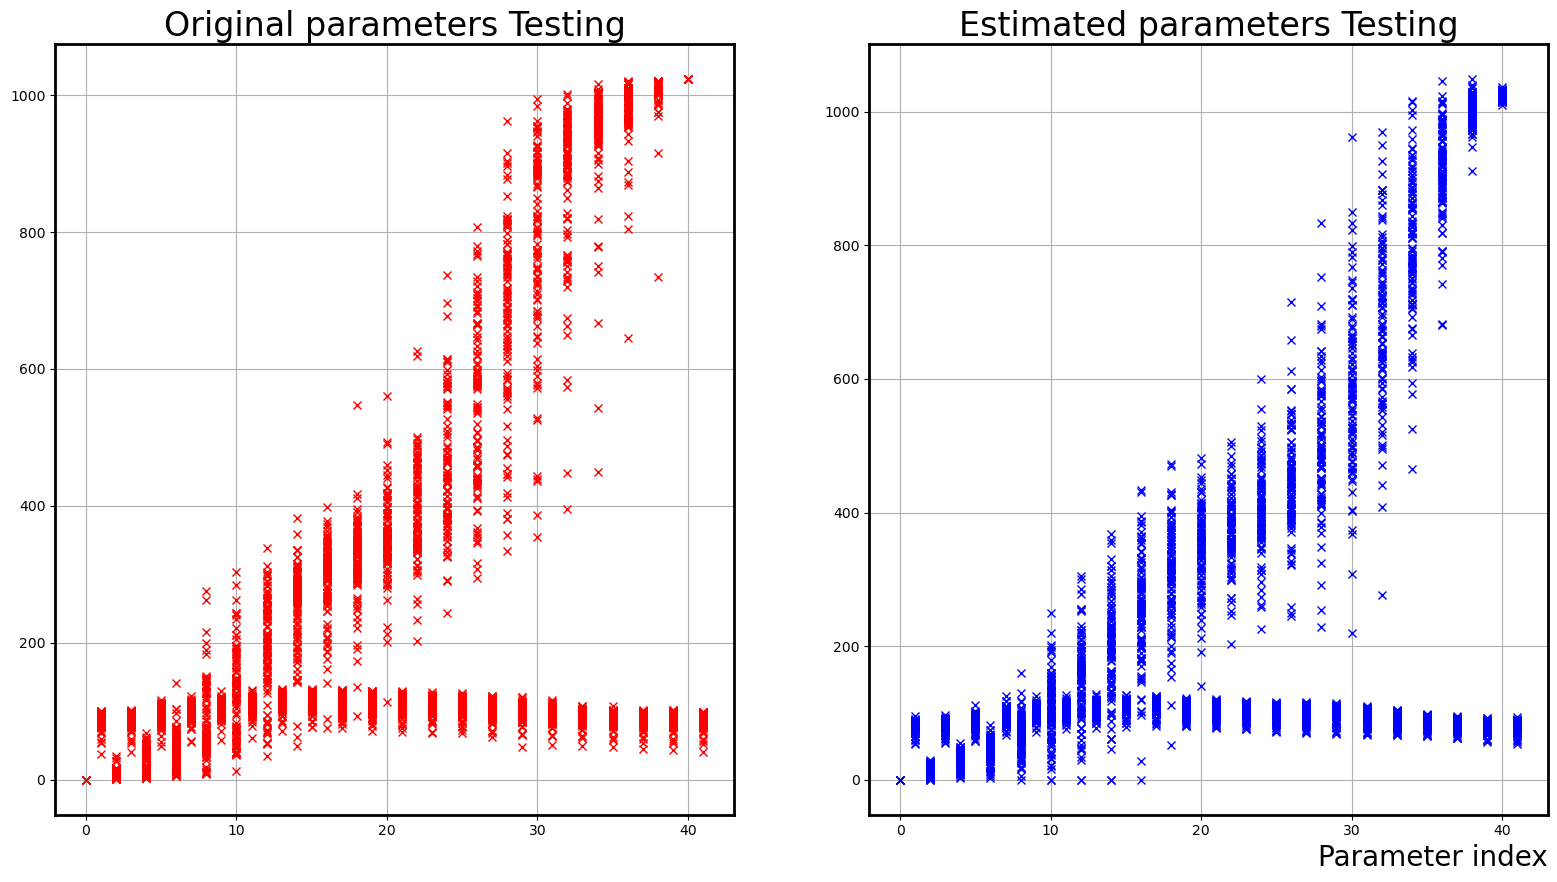

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

loaded
removemin
resmpling


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

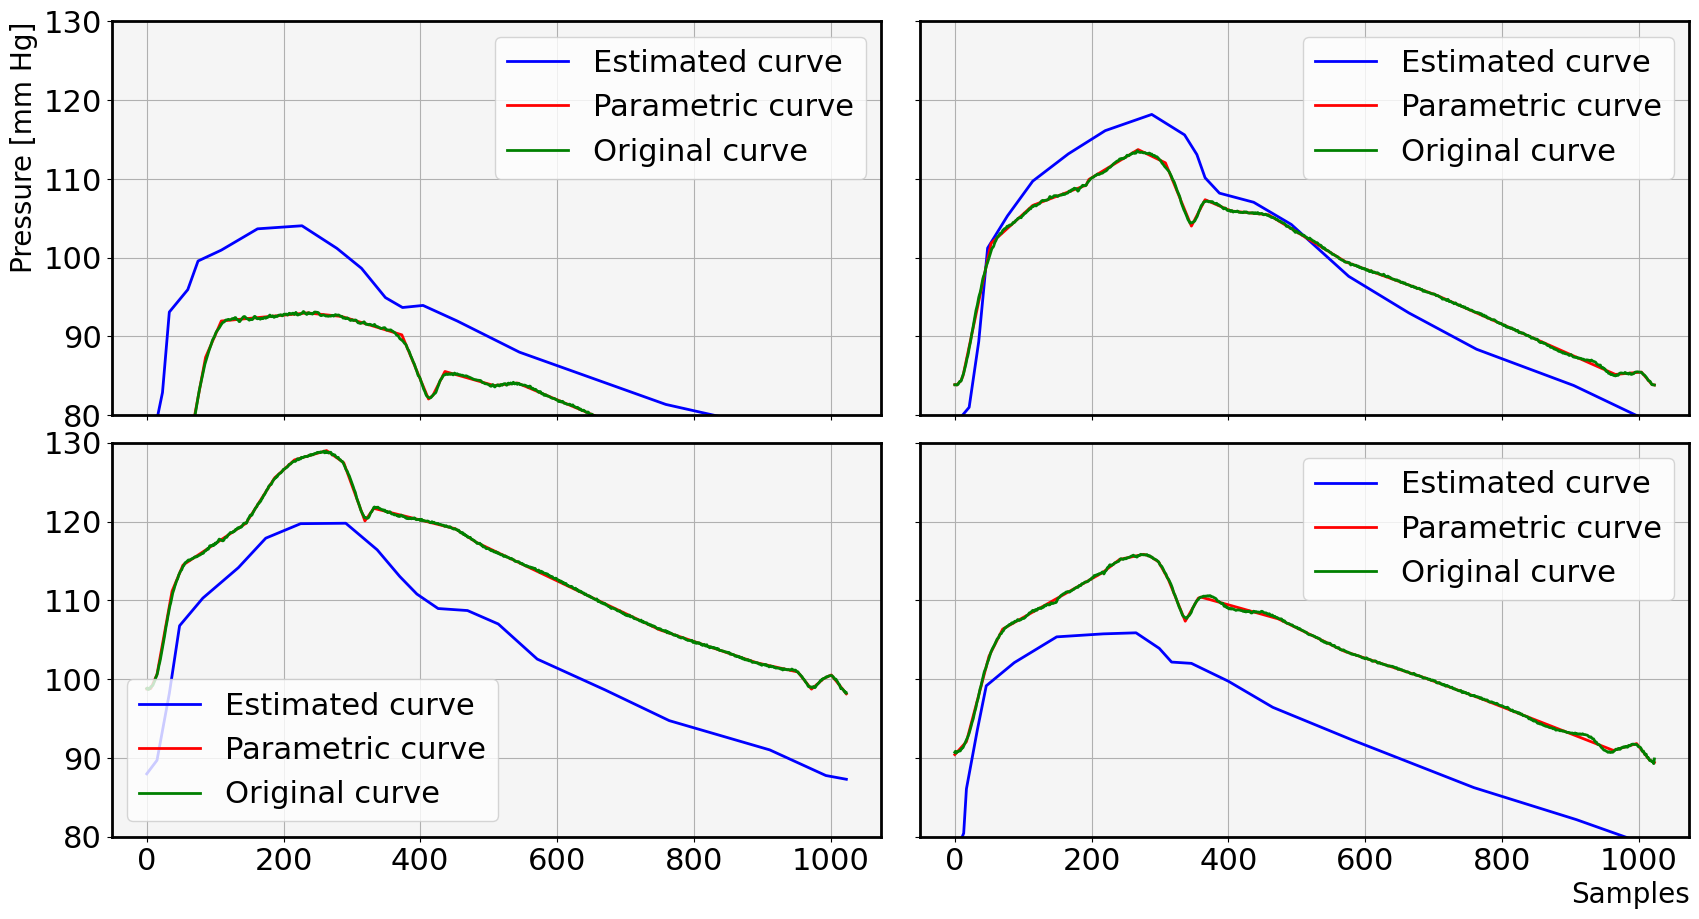

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

loaded
removemin
resmpling


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

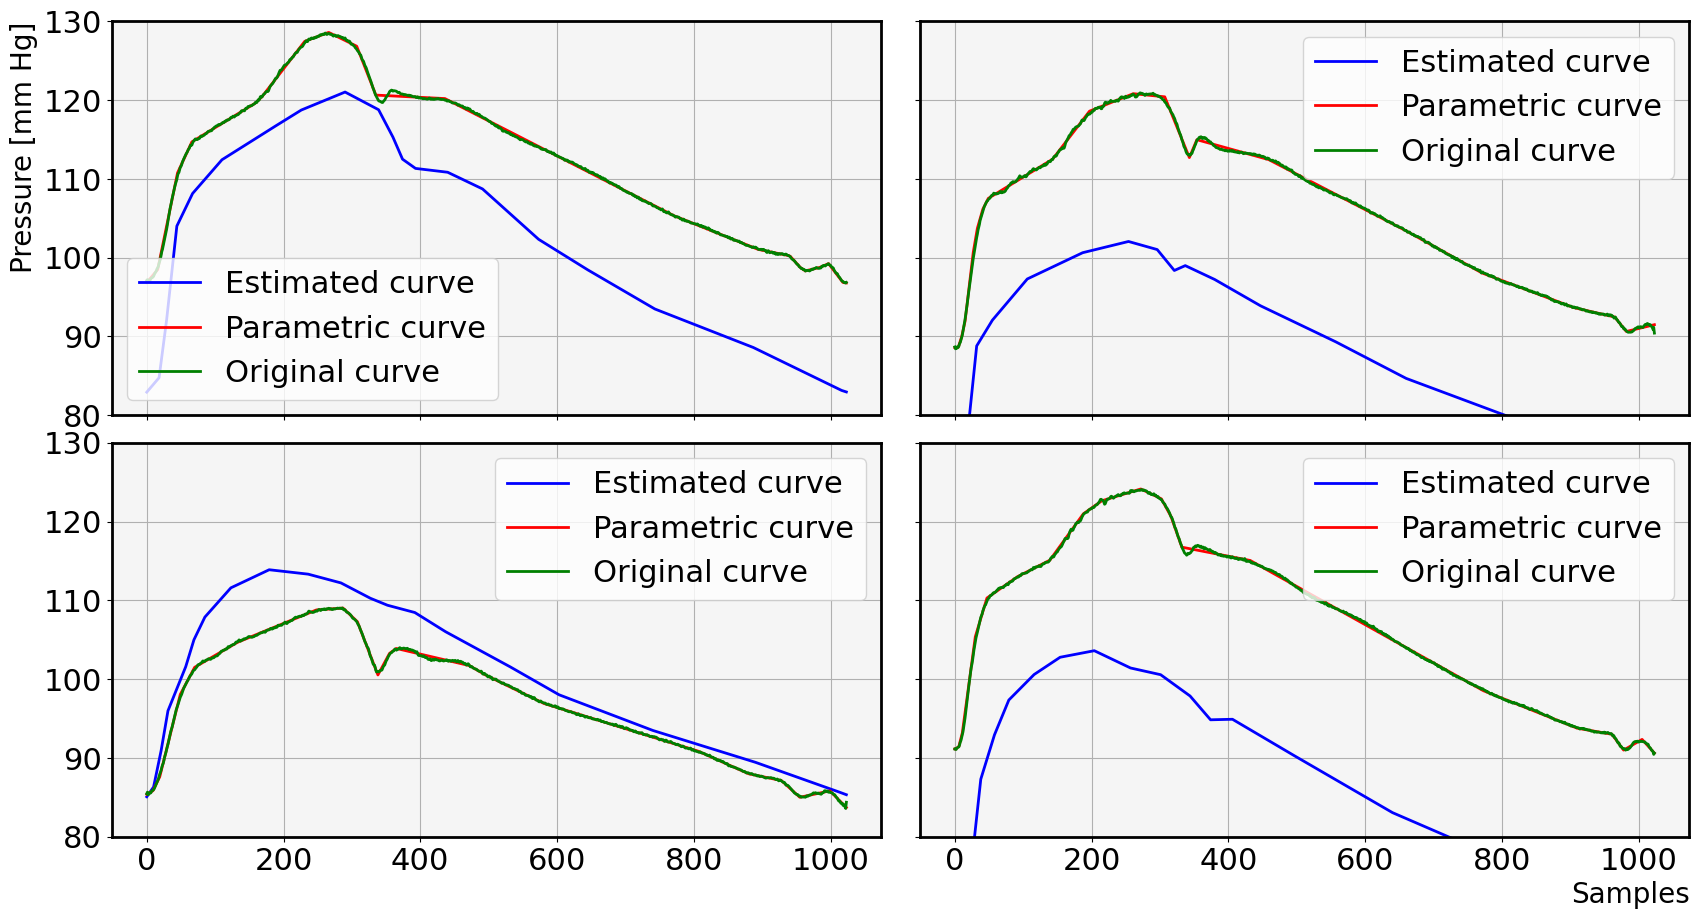

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

{'Testing': {'Curve': {'MAE': 10.265985247372, 'MSE': 159.53625584651166, 'PearsonR': 0.6307406660569004, 'PearsonP': 0.0, 'SpearmanRs': 0.6456588136460155, 'R2': -0.5696018173218609, 'MeanError': 5.981994649403402, 'VarError': 123.75199586102082, 'MAEmean': 10.03676753868868, 'Rmean': 0.304410596804133, 'MAEform': 0.0543, 'Rform': 0.9564974247450371}, 'Paras': {'MAE': 48.305829597460125, 'MSE': 8797.623413730666, 'PearsonR': 0.9596939642733038, 'PearsonP': 0.0}}, 'Validation': {}}
MAE:  10.265985247372
MSE:  159.53625584651166
Pearson:  0.6307406660569004
MAEform:  0.0543
Testing finished.
(7600,)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

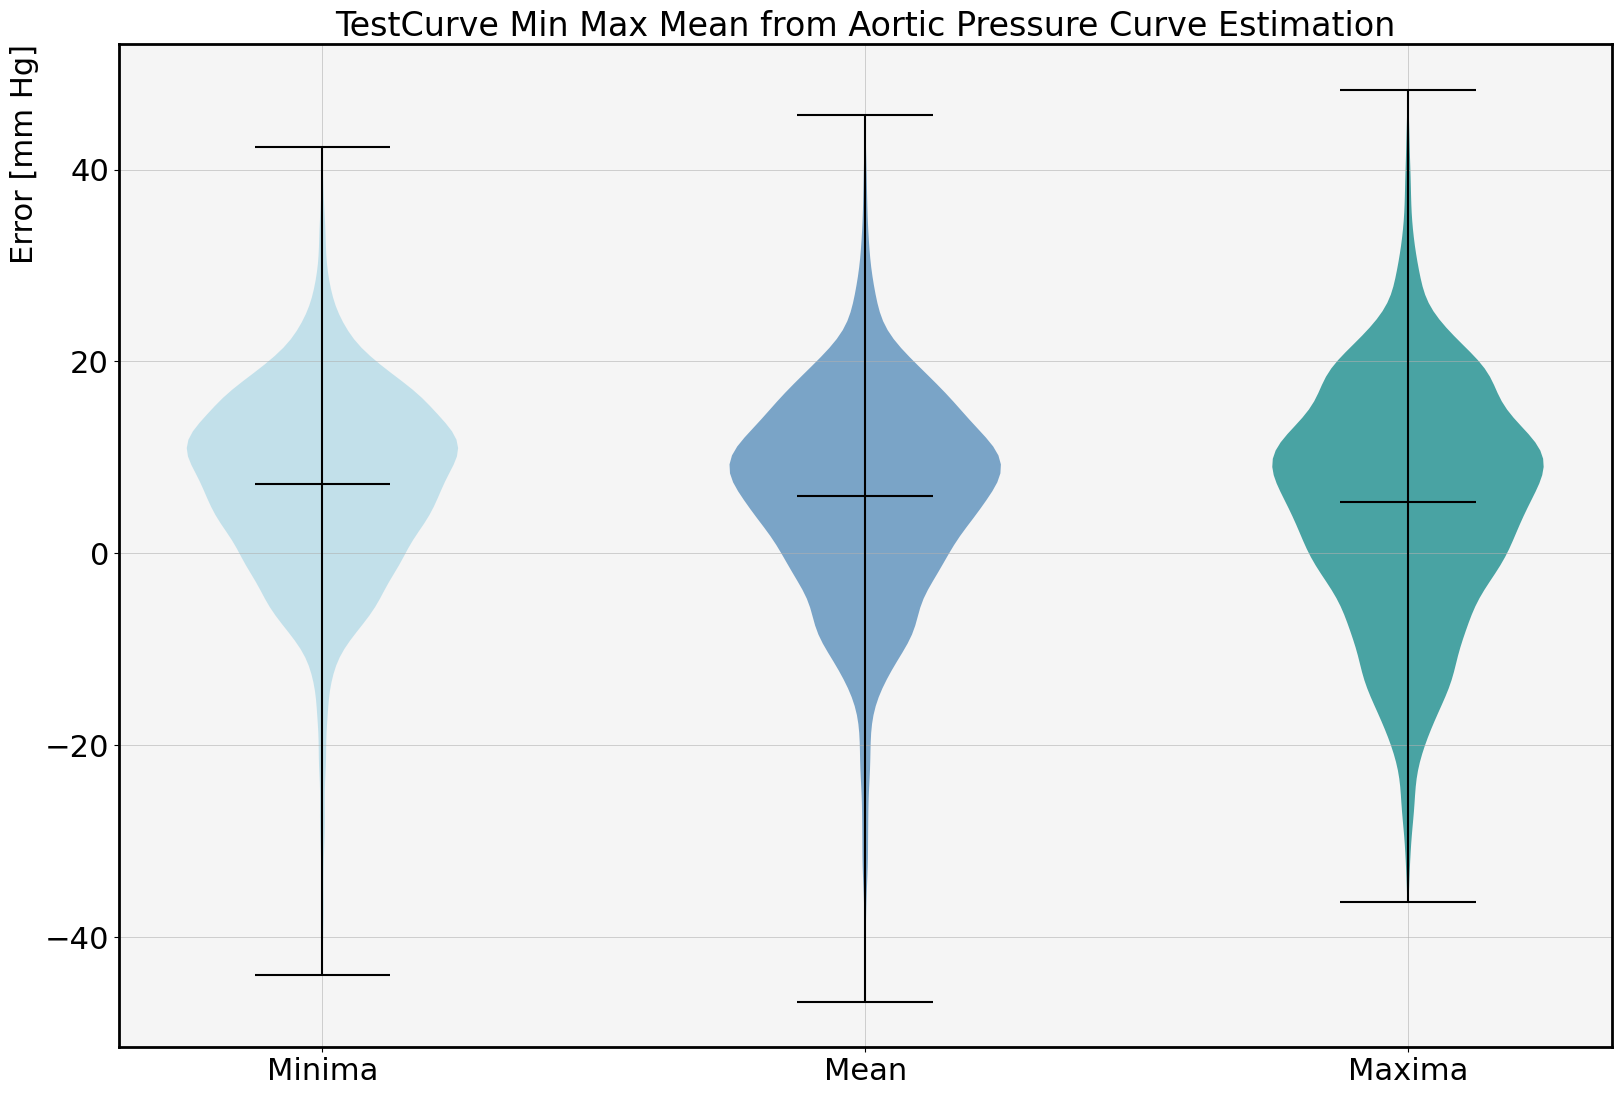

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

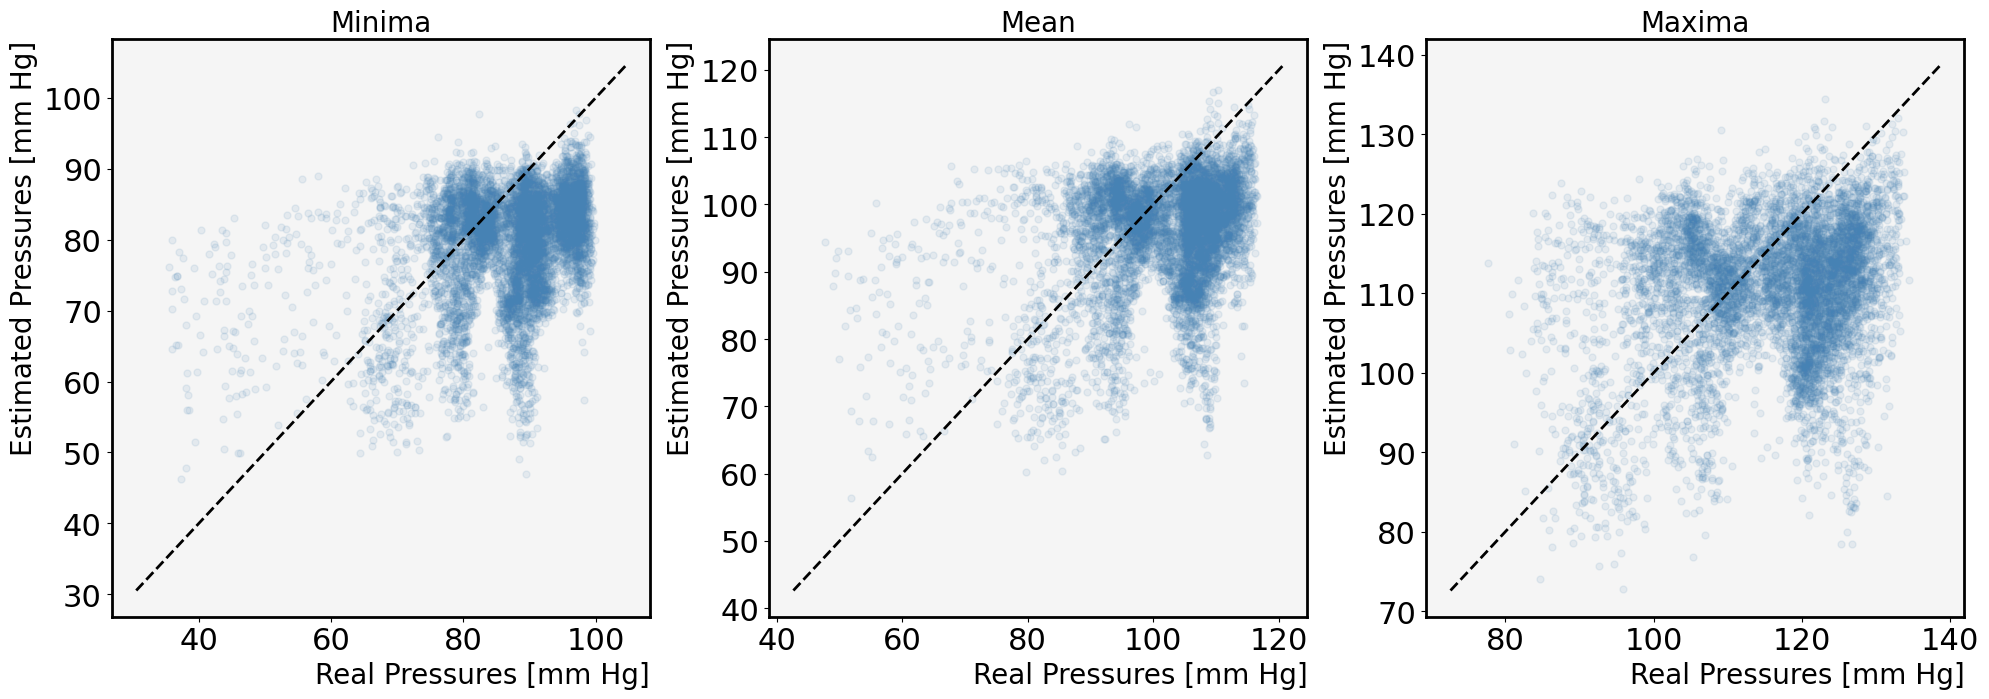

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

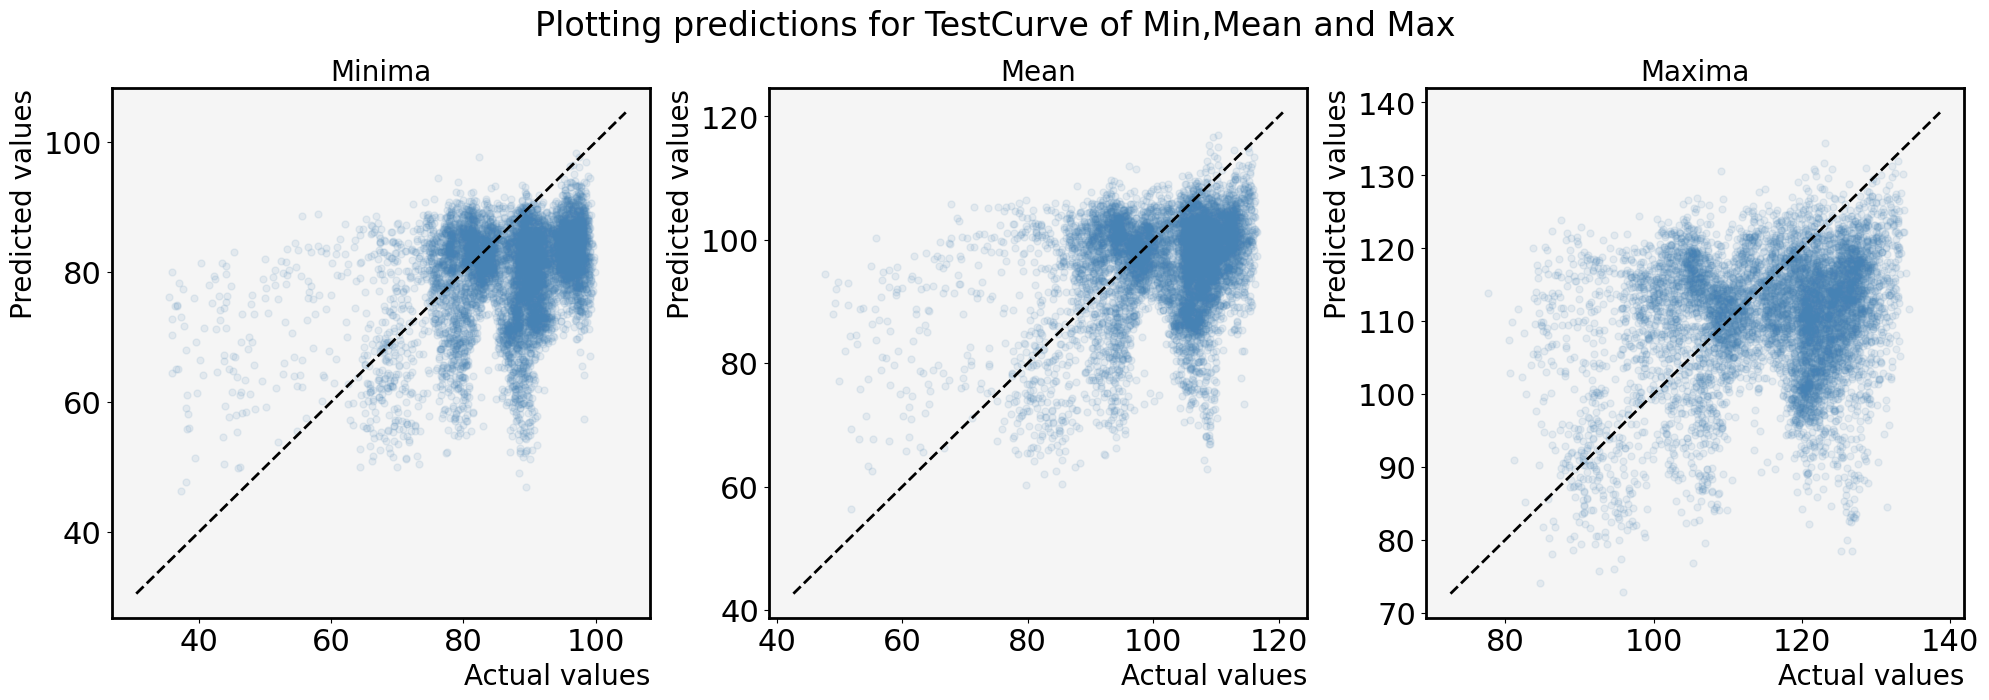

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

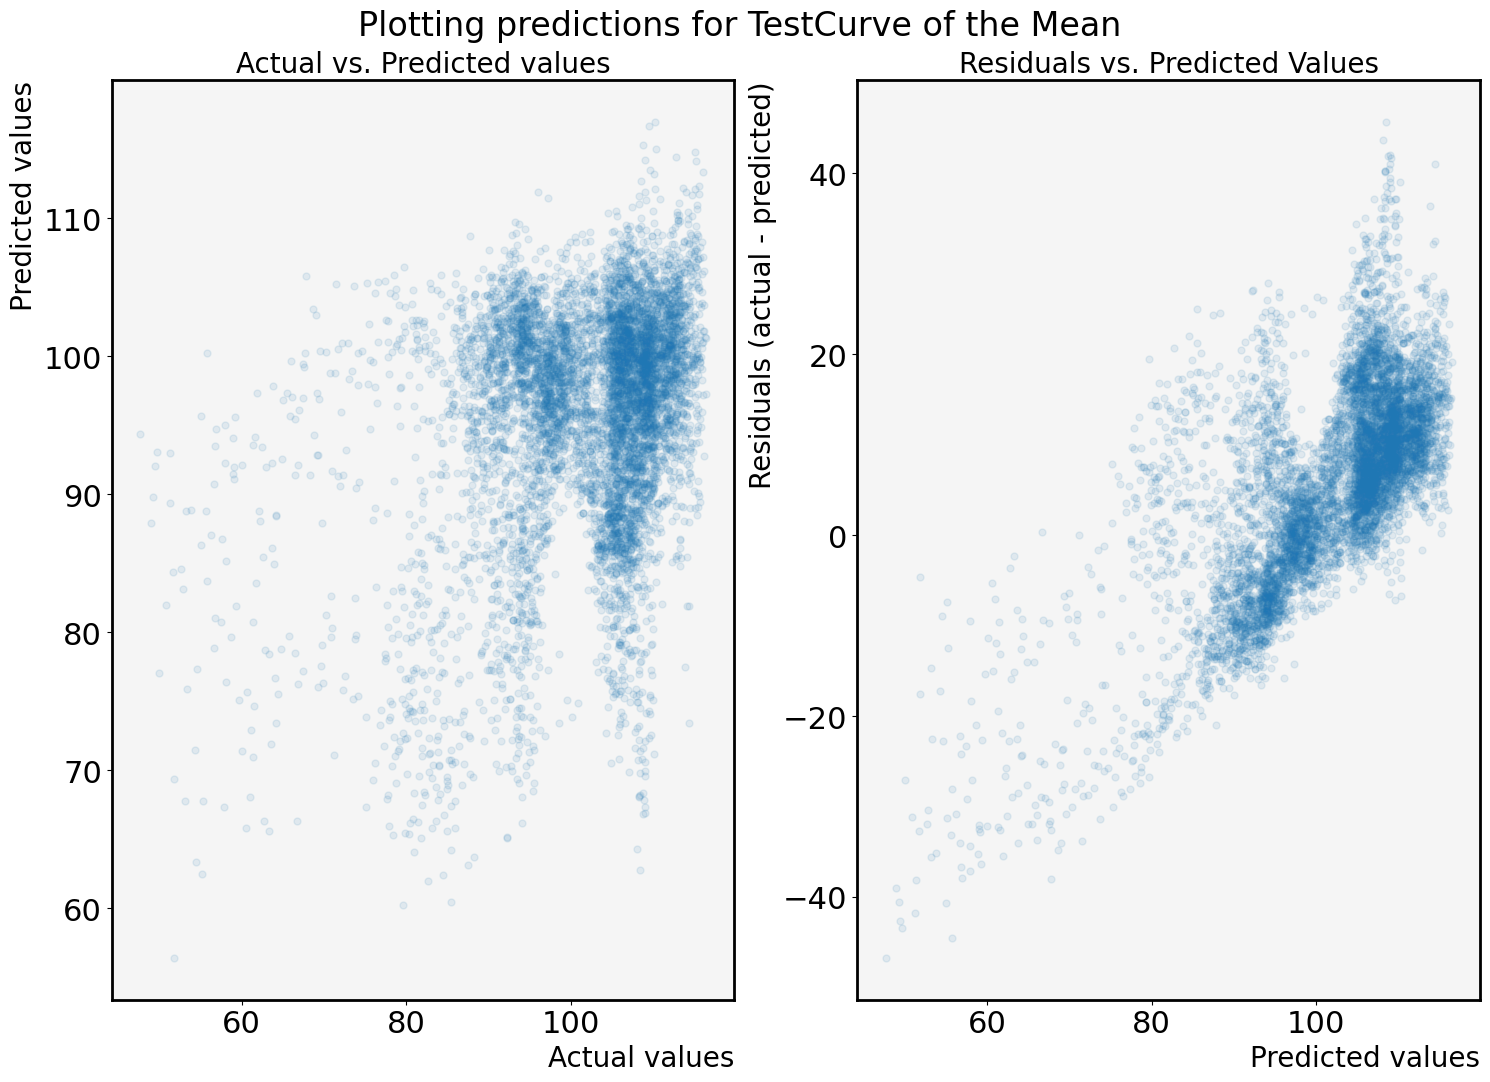

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

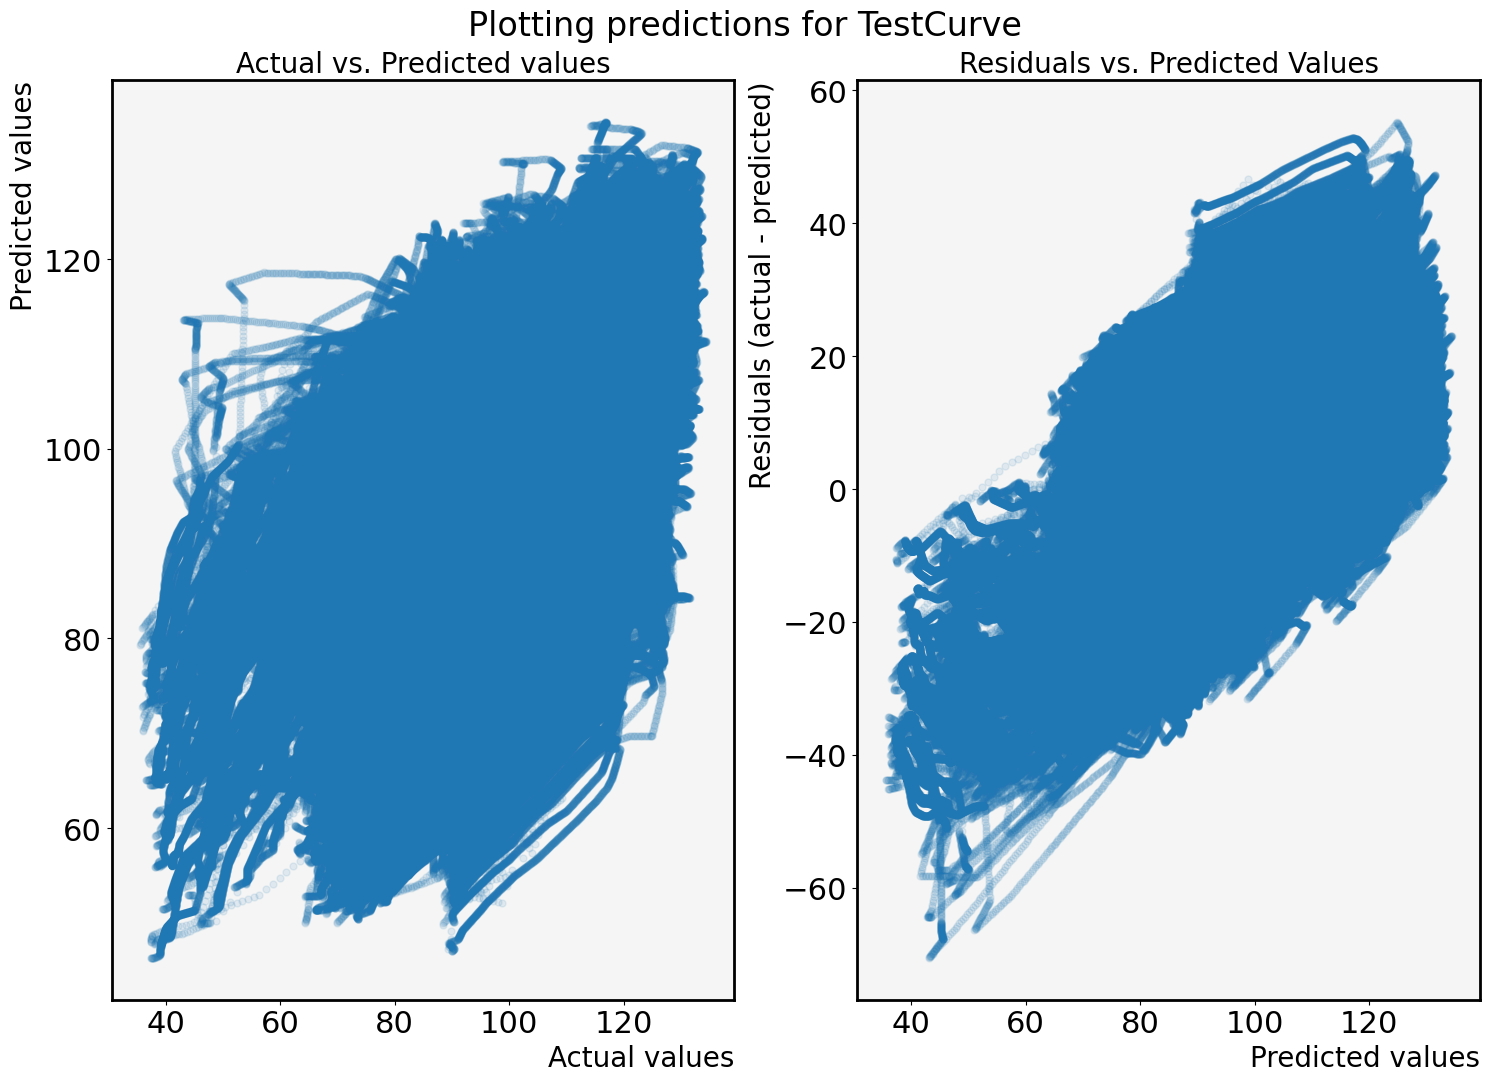

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

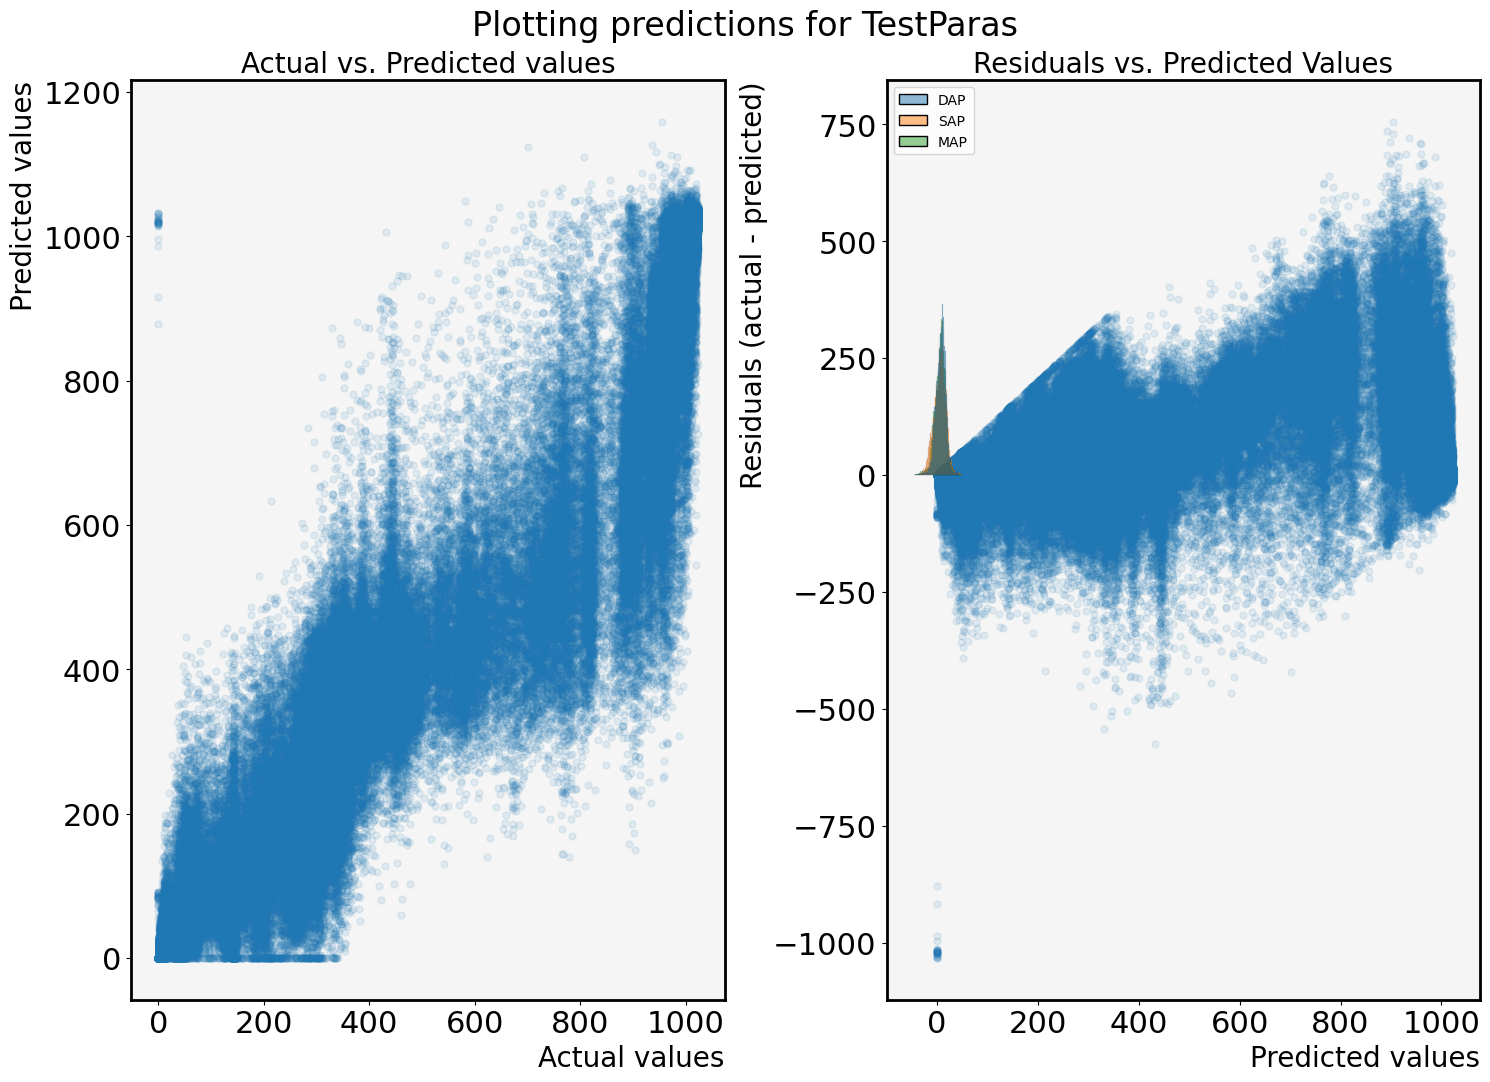

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

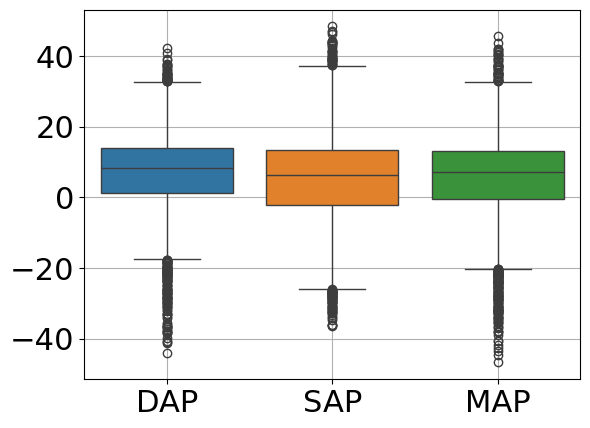

(1024,)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Pearson correlation coefficient mean 0.9722698401676244
MSE 139.89636285844398
MAE 8.909694613756729
Pearson number 0.9722698401676244


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

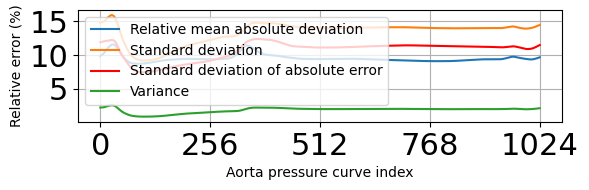

In [6]:
rel_err_config = {
    "std" : True,
    "var" : True,
    "mean" : True,
    "s_name" : None,
}
mae, mse, pn = plot_relative_error_aorta(y_test_real, y_test_preds_recon_a, **rel_err_config)

consecutive_error_blockwise(y_test_real, y_test_preds_recon_a, p_test)

plot_appended_recon_curves(y_test_preds_recon[0:16], y_test_recon[:16], "Testing Reconstructed Signals", sParaType, recon_given=True, bSave=bPlotGraphics,fSavePath=path, bShow=bShowGraphics)

plot_appended_recon_curves(y_test_preds_recon[100:116], y_test_recon[100:116], "Testing Reconstructed Signals Part2", sParaType, recon_given=True, bSave=bPlotGraphics,fSavePath=path, bShow=bShowGraphics)
#error_curves(y_test_recon, y_test_preds_recon, TP.sParaType, recon_given=True, title="Testing Error Distribution", bSave=bPlotGraphics,fSavePath=path, bShow=bShowGraphics)
#error_curves_mean_form(y_test_recon, y_test_preds_recon, TP.sParaType, recon_given=True, title="Testing", bSave=bPlotGraphics,fSavePath=path, bShow=bShowGraphics)
plot_parameters(y_test_preds, y_test,"Testing", bSave=bPlotGraphics,fSavePath=path, bShow=bShowGraphics)

ind = [5,25,40,50]
pig_plot = []
for k in ind:
    pig_plot.append(p_test[k])
aorta_seg_test = reload_aorta_segs_from_piginfo(data_path, pig_plot, False, sNormAorta=sNormAorta, bResampled=bResampleParas, iResampleLen=1024, )
plot_4_recon_curves_paper(y_test_preds_recon, y_test_recon, "Testing Reconstructed Signal", sParaType,
                    segment=aorta_seg_test, recon_given=True,ind=ind, bSave=bPlotGraphics,fSavePath=path, bShow=True)


ind = [100,125,140,150]
pig_plot = []
for k in ind:
    pig_plot.append(p_test[k])
aorta_seg_test = reload_aorta_segs_from_piginfo(data_path, pig_plot, False, bResampled=bResampleParas, iResampleLen=1024, sNormAorta=sNormAorta)
plot_4_recon_curves_paper(y_test_preds_recon, y_test_recon, "Testing Reconstructed Signal Part2", sParaType,
                    segment=aorta_seg_test, recon_given=True,ind=ind, bSave=bPlotGraphics,fSavePath=path, bShow=True)




M = EvaMetrics(path)
M.calc_metrics(y_test_real, y_test_preds_recon_a, sParaType, "TestCurve", bSave=bPlotGraphics)
#M.calc_metrics(y_test_recon_a, y_test_preds_recon_a, TP.sParaType, "TestRecon", bSave=bPlotGraphics)
M.calc_metrics(y_test, y_test_preds.numpy(), sParaType, "TestParas", bParas=True, bSave=bPlotGraphics)


M.gather_info()
print(M.metrics["Compact"])
print("MAE: ", M.metrics["Compact"]["Testing"]["Curve"]["MAE"])
print("MSE: ", M.metrics["Compact"]["Testing"]["Curve"]["MSE"])
print("Pearson: ", M.metrics["Compact"]["Testing"]["Curve"]["PearsonR"])
print("MAEform: ", M.metrics["Compact"]["Testing"]["Curve"]["MAEform"])
print("Testing finished.")

DAP = np.min(y_test_real, axis=1)
print(DAP.shape)
DAP = DAP-np.min(y_test_preds_recon_a, axis=1)
SAP =np.max(y_test_real, axis=1) -np.max(y_test_preds_recon_a, axis=1)
MAP = np.mean(y_test_real, axis=1) -np.mean(y_test_preds_recon_a, axis=1)
y_test_preds_recon_a = y_test_preds_recon_a + 10
mae, mse, pn = plot_relative_error_aorta(y_test_real, y_test_preds_recon_a, **rel_err_config)